<a href="https://colab.research.google.com/github/valencorrea/7506R-2C2022-GRUPO14/blob/main/7506R_TP1_GRUPO14_ENTREGA_ds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

______________________________________
# <center>**Trabajo Practico Nº1 para la Materia *Organización de Datos***</center>

*Integrantes*: 
- 103963	Carolina Di Matteo	cdimatteo@fi.uba.ar
- 101231	Pablo Salvador Dimartino	pdimartino@fi.uba.ar
- 100113	Juan Sebastian Burgos	jsburgos@fi.uba.ar
- 104415	Valentina Laura Correa	vcorrea@fi.uba.ar

*Grupo*: 14

*Repositorio*: [github](https://github.com/valencorrea/7506R-2C2022-GRUPO14)

*Curso*: Rodriguez

*Cuatrimestre*: 2c2022
______________________________________



**Set Up**

In [1]:
# Importamos las liberias para los manejos de datos y graficos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import PercentFormatter
from google.colab import drive

# Establecemos conecciones necesarias para poder usar nuestra base
drive.mount('/content/drive')

# Accedemos al archivo a analizar
properati=pd.read_csv('/content/drive/MyDrive/📔 Organización de Datos (75.06)/TPS/TP1/properati_argentina_2021.csv')
# properati=pd.read_csv('properati_argentina_2021.csv')


import warnings
warnings.filterwarnings('ignore')


Mounted at /content/drive


#  **1. Análisis Exploratorio y Preprocesamiento de Datos**

## **1a. Exploración Inicial**
A continuación se realizara un análisis general de cada una de las variables presentes en el dataframe.

In [2]:
df = properati.copy()
df.dtypes

id                           object
start_date                   object
end_date                     object
created_on                   object
latitud                     float64
longitud                    float64
place_l2                     object
place_l3                     object
place_l4                     object
place_l5                     object
place_l6                    float64
operation                    object
property_type                object
property_rooms              float64
property_bedrooms           float64
property_surface_total      float64
property_surface_covered    float64
property_price              float64
property_currency            object
property_title               object
dtype: object

Actualmente los únicos dos tipos de datos que tenemos son Float64 y Object.

Viendo las primeras entradas, podemos observar que el tipo Object oculta fechas que se adecuan mejor al tipo de datos DateTime.

In [3]:
df.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
0,XZq2dFGxBiboHY3Bo/tqlw==,2021-09-09,2022-01-27,2021-09-09,-38.957632,-68.105443,Neuquén,NaN,NaN,NaN,NaN,Venta,Casa,6.0,NaN,NaN,206.0,NaN,NaN,Casa - Capital
1,8afoK+yMH/rnnlYiktwgNA==,2021-09-09,2021-10-23,2021-09-09,-34.888878,-56.092368,Montevideo,NaN,NaN,NaN,NaN,Venta,Casa,4.0,3.0,193.0,193.0,390000.0,USD,Casa - Malvín
2,iVaG5rBB47dd1Ya4BMXREA==,2021-09-09,2022-03-09,2021-09-09,-32.488717,-58.257499,Entre Ríos,NaN,NaN,NaN,NaN,Venta,Casa,NaN,NaN,110.0,45.0,47000.0,USD,Casa - Uruguay
3,QE1QVMWKAHWkd0qT0FtPWA==,2021-09-09,2022-01-27,2021-09-09,-34.900165,-54.808453,Maldonado,NaN,NaN,NaN,NaN,Venta,Casa,NaN,3.0,NaN,180.0,400000.0,USD,Casa - El Chorro
4,tJ5lSk7IysG/71OGhacNZA==,2021-09-09,2022-01-27,2021-09-09,-38.954528,-68.041862,Neuquén,NaN,NaN,NaN,NaN,Venta,PH,3.0,2.0,NaN,98.0,102000.0,USD,PH - Villa Farrell


### Preparación de los datasets

Aplicamos los filtros necesarios que figuran en los requerimientos, y cambiamos el dtype de las fechas a DateTime. 

Por otro lado, determinamos tanto el modelo a entrenar como el que usaremos para realizar las predicciones.

In [4]:
df = df.loc[df['property_type'].isin(["Casa", "PH", "Departamento"])].loc[df['place_l2'].isin(["Capital Federal"])].loc[df['operation'].isin(["Venta"])].loc[df['property_currency'].isin(["USD"])]
df['start_date']= pd.to_datetime(df['start_date'])
df['created_on']= pd.to_datetime(df['created_on'])
df.replace(to_replace="9999-12-31", value="", inplace=True)
df['end_date']= pd.to_datetime(df['end_date'])

train = df.sample(frac=0.8, random_state=200)
test = df.drop(train.index)
df.columns.tolist()

['id',
 'start_date',
 'end_date',
 'created_on',
 'latitud',
 'longitud',
 'place_l2',
 'place_l3',
 'place_l4',
 'place_l5',
 'place_l6',
 'operation',
 'property_type',
 'property_rooms',
 'property_bedrooms',
 'property_surface_total',
 'property_surface_covered',
 'property_price',
 'property_currency',
 'property_title']

### Descripción de Campos

`id`: Identificador del aviso

`start_date`: Fecha de alta del aviso

`end_date`: Fecha de baja del aviso

`created_on`: Fecha de alta de la primera versión del aviso

`latitud`: Ubicación geográfica

`longitud`: Ubicación geográfica

`place_l2`: Nivel administrativo 2, usualmente provincia

`place_l3`: Nivel administrativo 3, usualmente ciudad

`place_l4`: Nivel administrativo 4, usualmente barrio

`place_l5`: Nivel administrativo 5

`place_l6`: Nivel administrativo 6

`operation`: Tipo de operación (venta, alquiler)

`property_type`: Tipo de propiedad (casa, departamento, ph)

`property_rooms`: Cantidad de ambientes

`property_bedrooms`: Cantidad de dormitorios

`property_surface_total`: Superficie total en metros cuadrados

`property_surface_covered`: Superficie cubierta en metros cuadrados

`property_price`: Precio publicado en el anuncio

`property_currency`: Moneda del precio publicado

`property_title`: Título del anuncio

### Variables Cuantitativas: Medidas de Resumen

Calculamos, para la totalidad de las variables que nos brinda el dataset:
- media
- mediana
- q1
- q3 
- moda

In [5]:
df.describe().loc[['mean', '25%', '75%', 'std']].append(df.median().rename("median"))

,latitud,longitud,place_l5,place_l6,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
mean,-34.591481,-58.449795,NaN,NaN,2.822799,2.014629,109.092970,87.931932,226238.207185
25%,-34.615975,-58.466522,NaN,NaN,2.000000,1.000000,45.000000,40.000000,95000.000000
75%,-34.577413,-58.408862,NaN,NaN,4.000000,3.000000,105.000000,88.000000,237000.000000
std,0.181719,0.292630,NaN,NaN,1.426148,1.129767,980.401976,990.927129,318603.483648
median,-34.595790,-58.439000,NaN,NaN,3.000000,2.000000,65.000000,58.000000,143900.000000


### Variables Cualitativas: Cantidades y Frecuencias

Realizamos, para las variables `place_l3`, `place_l4` y `property_type` un cálculo de los diferentes valores así también como sus respectivas frecuencias.

In [6]:
print(f"place_l3 tiene {df.nunique()['place_l3']} valores diferentes")

place_l3 tiene 57 valores diferentes


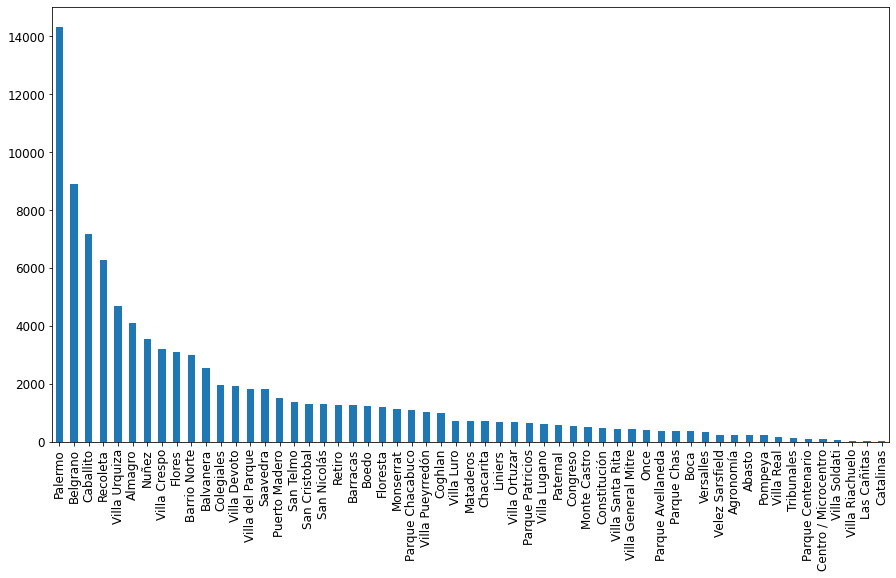

In [7]:
fig, ax = plt.subplots()
df['place_l3'].value_counts().plot(ax=ax, kind='bar', figsize=(15,8), fontsize=12)

In [8]:
print(f"place_l4 tiene {df.nunique()['place_l4']} valores diferentes")

place_l4 tiene 4 valores diferentes


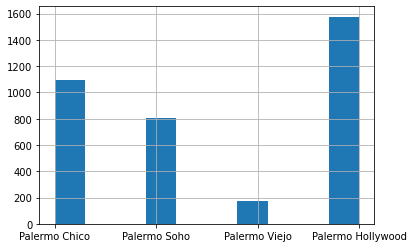

In [9]:
df['place_l4'].hist()

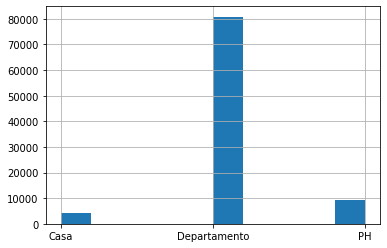

In [10]:
df['property_type'].hist()

In [11]:
print(f"property_type tiene {df.nunique()['property_type']} valores diferentes")

property_type tiene 3 valores diferentes


### Determinación de Variables Irrelevantes

Finalmente, podremos decir que dejamos fuera de este análisis particular a las a las siguientes variables que detallamos a continuación:

- `operation`: Sólo hay un tipo de operación según lo solicitado en la consigna y es "Venta", con lo cual la consideramos irrelevante en el análisis.
- `property_currency`: Sólo hay un tipo de cambio según lo solicitado en la consigna y es "USD", con lo cual la consideramos irrelevante en el análisis.
- `place_l5`: De analizar previamente el dataset con el cual estamos trabajando, detectamos que la columna en cuestión se encuentra vacía, con lo cual la consideramos irrelevante en el análisis.
- `place_l6`: De analizar previamente el dataset con el cual estamos trabajando, detectamos que la columna en cuestión se encuentra vacía, con lo cual la consideramos irrelevante en el análisis.
- `property_title`: De conocer previamente la información que contiene el dataset, sabemos que la variable en cuestión almacena un único título por publicación, con lo cual la consideramos irrelevante en el análisis.

### Análisis Gráfico de las Distribuciones de las Variables

##### Densidad de la variable `latitud`

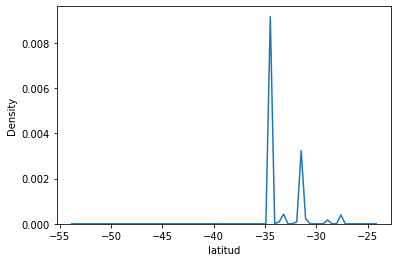

In [12]:
#grf = df['latitud'].plot.kde(title="Densidad variable Start date",xlabel="x",ylabel="y").xlim(-10, 10)
#sns.displot(df.latitud, hist=False, kde_kws={'clip': (-10.0, 10.0)})
# ver despues de machearlas con los property_types 
sns.kdeplot(data=df.latitud, gridsize=70)

##### Densidad de la variable `longitud`

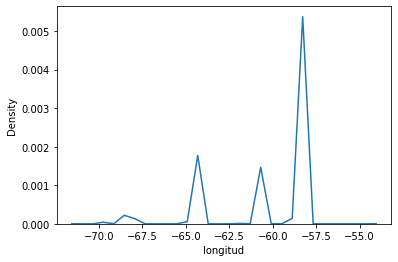

In [13]:
sns.kdeplot(data=df.longitud, gridsize=30)


##### Densidad de la variable `property_price`

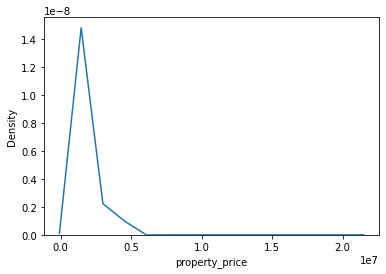

In [14]:
sns.kdeplot(data=df.property_price, gridsize=15)


##### Densidad de la variable `property_rooms`

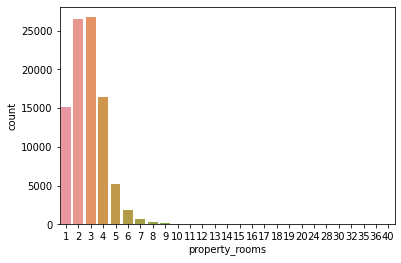

In [15]:
sns.countplot(x=df['property_rooms'].dropna().astype('int32'))

##### Densidad de la variable `property_surface_covered`

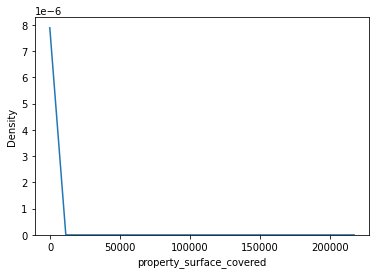

In [16]:
sns.kdeplot(data=df.property_surface_covered, gridsize=20)


### Análisis de las Correlaciones existentes entre las Variables

In [17]:
df.drop(["place_l5", "place_l6"], axis = 1, inplace = True)

In [18]:
#columns = df.columns.tolist()
#df_pariplot = df[columns].copy()
#graf_pairplot = sns.pairplot(data=df_pariplot, hue="property_type", palette=["r", "g", "b"])

## **1b. Datos Faltantes**
A continuación se realizara un análisis sobre los datos faltantes del dataframe.

### Análisis a Nivel Columna

Graficamos, para cada variable, el porcentaje (diferente de cero) de datos faltantes con respecto al total del dataset en escala logarítmica.

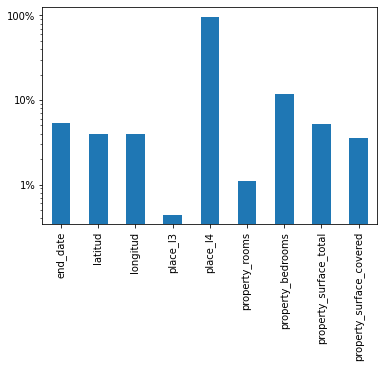

In [19]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.yaxis.set_major_formatter(PercentFormatter())
(df.isnull().sum() * 100 / len(df)).replace(0,np.nan).dropna(axis=0,how="all").plot(ax=ax, kind='bar')

### Análisis a Nivel Fila

Graficamos el porcentaje de filas con n datos faltantes con respecto al total del dataset.

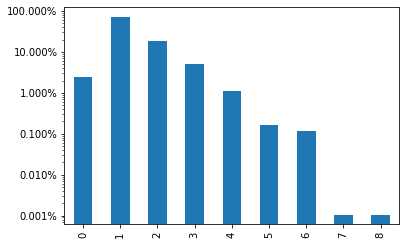

In [20]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.yaxis.set_major_formatter(PercentFormatter(decimals=3))
(df.isnull().sum(axis=1).value_counts().sort_index() * 100 / len(df)).plot(ax=ax, kind='bar')

### Reparación de Valores Faltantes

A continuación se detallan posibles estrategias para reparar los valores faltantes del dataset.

Reemplazamos las locaciones no definidas por el nivel superior

In [21]:
df.place_l3.fillna(df.place_l2, inplace=True)
df.place_l4.fillna(df.place_l3, inplace=True)

Reemplazamos la cantidad de dormitorios no definidos por la media calculada filtrando por cantidad total de habitaciones.


In [22]:
cant = df.loc[(df['property_bedrooms'].isna()) & (df['property_rooms'].notna())].property_rooms.value_counts().index.values

for i in cant:
    median = df.loc[(df['property_bedrooms'].notna()) & (df['property_rooms'] == i)].property_bedrooms.median()
    df.loc[(df['property_bedrooms'].isna()) & (df["property_rooms"] == i), "property_bedrooms"] = df.loc[(df['property_bedrooms'].isna()) & (df["property_rooms"] == i), "property_bedrooms"].fillna(median)


Luego reemplazamos la cantidad total de habitaciones no definidas por la media calculada filtrando por cantidad de dormitorios.

Esto redujo el porcentaje de valores no definidos para los dormitorios y habitaciones a menos de 1%, desde 10% y 1,5% respectivamente.

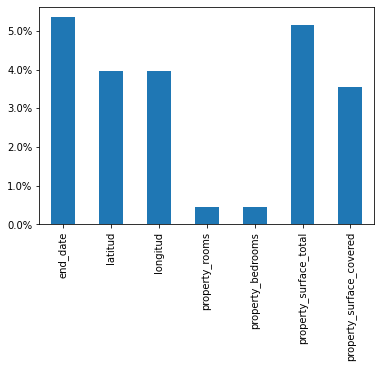

In [23]:
cant = df.loc[(df['property_rooms'].isna()) & (df['property_bedrooms'].notna())].property_bedrooms.value_counts().index.values

for i in cant:
    median = df.loc[(df['property_rooms'].notna()) & (df['property_bedrooms'] == i)].property_rooms.median()
    df.loc[(df['property_rooms'].isna()) & (df["property_bedrooms"] == i), "property_rooms"] = df.loc[(df['property_rooms'].isna()) & (df["property_bedrooms"] == i), "property_rooms"].fillna(median)
    
fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(PercentFormatter())
(df.isnull().sum() * 100 / len(df)).replace(0,np.nan).dropna(axis=0,how="all").plot(ax=ax, kind='bar')


Cuando se tiene la superficie total pero no la cubierta o viceversa, reemplazamos los valores faltantes con su contraparte

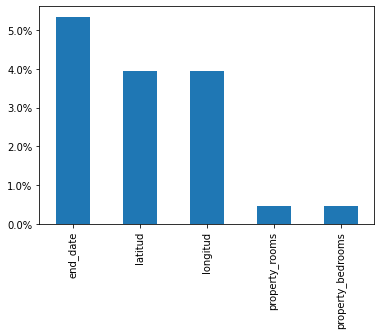

In [24]:
df.property_surface_total.fillna(df.property_surface_covered, inplace=True)
df.property_surface_covered.fillna(df.property_surface_total, inplace=True)

fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(PercentFormatter())
(df.isnull().sum() * 100 / len(df)).replace(0,np.nan).dropna(axis=0,how="all").plot(ax=ax, kind='bar')

# FALTA ARREGLAR LATITUD Y LONGITUD.

## **1c. Valores atípicos**

A continuación se realizara un análisis sobre los valores atípicos presentes en el dataframe.

### Detección

En la totalidad del dataset logramos detectar outliers tanto univariados (presentes en una unica variable) como multivariados (se encuentran en un espacio n-dimensional).




#### Outliers univariados

Utilizando los gráficos de tipo Box-Plot vamos a intentar identificarlos:

##### Property rooms

Como se puede observar en el siguiente grafico, tenemos una serie de valores atipicos referenciados a la cantidad de ambientes de las propiedades. Si tomamos en cuenta los extremos de los cuartiles que calculamos a continuacion, notamos que algunos quedan excesivamente altos en comparacion.

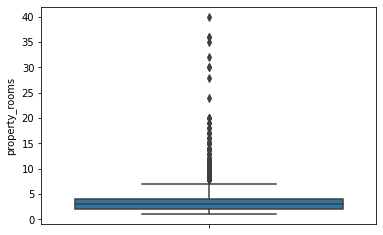

In [25]:
sns.boxplot(y=df.property_rooms)
plt.show()

In [26]:
# Cuartiles
Q1_property_rooms=df.describe().get("property_rooms").get("25%")
Q3_property_rooms=df.describe().get("property_rooms").get("75%")

print("El valor de Q1 es:", Q1_property_rooms)
print("El valor de Q3 es:", Q3_property_rooms)

# Rango intercuartil
IQR_property_rooms=Q3_property_rooms-Q1_property_rooms

# Limites Outliers
out_inf=Q1_property_rooms-1.5*IQR_property_rooms
out_sup=Q3_property_rooms+1.5*IQR_property_rooms
print("El limite inferior del Q1 es:", out_inf)
print("El limite superior del Q3 es:", out_sup)

El valor de Q1 es: 2.0
El valor de Q3 es: 4.0
El limite inferior del Q1 es: -1.0
El limite superior del Q3 es: 7.0


##### Property bedrooms

Al igual que los ambientes, podemos notar tambien aca la presencia de algunos valores lejanos a los extremos de los cuartiles que usamos de referencia. En particular tenemos uno notoriamente distanciado cercano al numero 70.

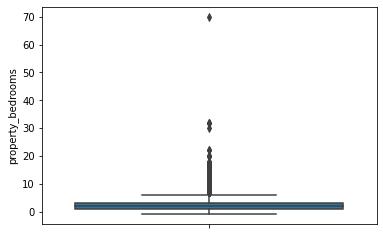

In [27]:
sns.boxplot(y=df.property_bedrooms)
plt.show()

In [28]:
# Cuartiles
Q1_property_bedrooms=df.describe().get("property_bedrooms").get("25%")
Q3_property_bedrooms=df.describe().get("property_bedrooms").get("75%")

print("El valor de Q1 es:", Q1_property_bedrooms)
print("El valor de Q3 es:", Q3_property_bedrooms)

# Rango intercuartil
IQR_property_bedrooms=Q3_property_bedrooms-Q1_property_bedrooms

# Limites Outliers
out_inf=Q1_property_bedrooms-1.5*IQR_property_bedrooms
out_sup=Q3_property_bedrooms+1.5*IQR_property_bedrooms
print("El limite inferior del Q1 es:", out_inf)
print("El limite superior del Q3 es:", out_sup)

El valor de Q1 es: 1.0
El valor de Q3 es: 3.0
El limite inferior del Q1 es: -2.0
El limite superior del Q3 es: 6.0


#### Outliers multivariados

A continuacion vamos a analizar la presencia de outliers utilizando el metodo de Mahalanobis.






##### Property rooms vs Property bedrooms

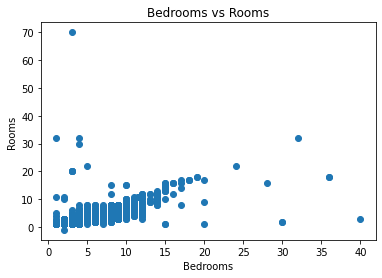

In [29]:
#Scatter Plot
plt.scatter(df.property_rooms,df.property_bedrooms)
plt.title('Bedrooms vs Rooms')
plt.xlabel('Bedrooms')
plt.ylabel('Rooms')
plt.show()

##### Property rooms vs Property surface total

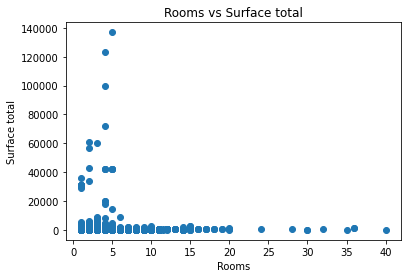

In [30]:
#Scatter Plot
plt.scatter(df.property_rooms,df.property_surface_total)
plt.title('Rooms vs Surface total')
plt.xlabel('Rooms')
plt.ylabel('Surface total')
plt.show()

##### Property rooms vs Property surface covered

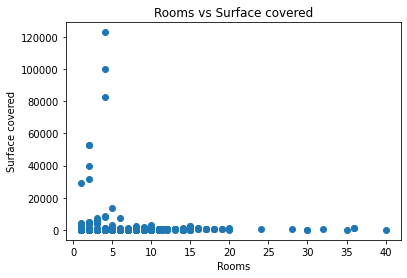

In [31]:
#Scatter Plot
plt.scatter(df.property_rooms,df.property_surface_covered)
plt.title('Rooms vs Surface covered')
plt.xlabel('Rooms')
plt.ylabel('Surface covered')
plt.show()

##### Property rooms vs Property price

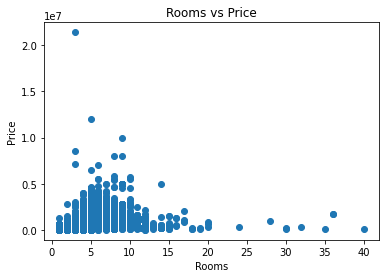

In [32]:
#Scatter Plot
plt.scatter(df.property_rooms,df.property_price)
plt.title('Rooms vs Price')
plt.xlabel('Rooms')
plt.ylabel('Price')
plt.show()

##### Property surface total vs Price -> Mahalanobis
Como podemos apreciar en el grafico, la mayor concentracion se presenta en la esquina inferior izquierda, aunque presenta algunos valores dispersos en las cercanias de ambos extremos. Por otro lado hay dos valores particularmente alejados.




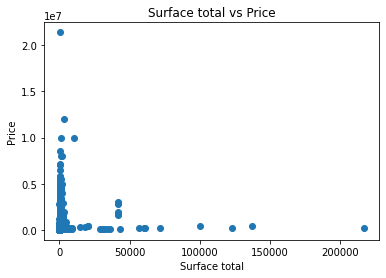

In [33]:
#Scatter Plot
plt.scatter(df.property_surface_total,df.property_price)
plt.title('Surface total vs Price')
plt.xlabel('Surface total')
plt.ylabel('Price')
plt.show()

Para poder determinar concretamente estos valores, nos ayudamos con el calculo de la distancia de mahalanobis para cada una de las observaciones presentes.

In [ ]:
# Calulo el vector de medias
vector_medias=np.mean(df[['property_price','property_surface_total']])

# Calculo la diferencia entre las observaciones y el vector de medias
diferencia_x = df[['property_price','property_surface_total']] - vector_medias

# Calculo matriz de covarianza y su inversa
covarianza=df[['property_price','property_surface_total']].cov().values
inv_covarianza = np.linalg.inv(covarianza)

# Calculamos el cuadrado de la distancia de mahalanobis
dist_mahalanobis = np.dot(np.dot(diferencia_x, inv_covarianza), diferencia_x.T) # me rompe la ram

#df['mahalanobis'] = dist_mahalanobis.diagonal()

#  **2. Agrupamiento**

#  **3. Clasificación**

#  **4. Regresión**

#  **5. Conclusiones**